In [121]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import networkx as nx
import itertools

plt.rcParams['figure.figsize'] = [4.5, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
pd.set_option('display.max_colwidth', None)
import numpy as np


from dse_do_utils import OptimizationEngine,ScenarioManager
import docplex.mp
from docplex.mp.model import Model

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<positron-console-cell-121>:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


https://how-to.aimms.com/Articles/332/332-Formulation-CVRP.html

In [122]:
def continuous_var_series(df, mdl,**kargs):
    return pd.Series(mdl.continuous_var_list(df.index, **kargs), index = df.index)

def binary_var_series(df, mdl,**kargs):
    return pd.Series(mdl.binary_var_list(df.index, **kargs), index = df.index)

def integer_var_series(df, mdl,**kargs):
    '''Create a Series of integer dvar for each row in the DF. Most effective method. Best practice.
    Result can be assigned to a column of the df.
    Usage:
        df['xDVar'] = mdl.integer_var_series(df, name = 'xDVar')
    Args:
        mdl: CPLEX Model
        df: DataFrame
        **kargs: arguments passed to mdl.integer_var_list method. E.g. 'name'
        
    :returns: pandas.Series with integer dvars, index matches index of df
    '''
    #We are re-using the index from the DF index:
    return pd.Series(mdl.integer_var_list(df.index, **kargs), index = df.index)


def extract_solution(df, extract_dvar_names=None, drop_column_names=None, drop:bool=True):
    """Generalized routine to extract a solution value. 
    Can remove the dvar column from the df to be able to have a clean df for export into scenario."""
    if extract_dvar_names is not None:
        for xDVarName in extract_dvar_names:
            if xDVarName in df.columns:
                df[f'{xDVarName}Sol'] = [dvar.solution_value for dvar in df[xDVarName]]
                if drop:
                    df = df.drop([xDVarName], axis = 1)
    if drop and drop_column_names is not None:
        for column in drop_column_names:
            if column in df.columns:
                df = df.drop([column], axis = 1)
    return df



    
# returns all undirected edges between vertices
def pairs(vertices):
    return itertools.combinations(vertices, 2)

In [123]:
MODEL_NAME = 'ToyVRP'
SCENARIO_NAME = 'scenario_1' 
sm = ScenarioManager(model_name=MODEL_NAME, scenario_name=SCENARIO_NAME)

sm.InputTables={}

# Create data

In [124]:
number_of_clientes = 2
number_of_depots = 1
number_of_locations = number_of_clientes + number_of_depots
number_of_trucks = 1
Truck_capacity= 1000

In [125]:
Demand = pd.DataFrame([])
Demand["GasStationID"] = ["Client" +str(i) for i in range(1,number_of_clientes+1)]
Demand["Quantity"]  = [np.random.randint(1, 10) for i in range(1,number_of_clientes+1)]
display(Demand.head())

Supply = pd.DataFrame([])
Supply["TerminalID"]=["Depot" +str(i) for i in range(1,number_of_depots+1)]
Supply.loc[:,"Quantity"]=1000
display(Supply.head())

Locations = pd.DataFrame([])
Locations["LocationName"] = np.concatenate([Demand["GasStationID"].values , Supply["TerminalID"].values])
Locations["Latitude"] = np.random.rand(number_of_locations)*20
Locations["Longitude"] = np.random.rand(number_of_locations)*10
Locations["Type"]= ["Client" for i in range(0,number_of_clientes)] + ["Depot" for i in range(0,number_of_depots)] 
display(Locations.head())


Trucks = pd.DataFrame([])
Trucks["TruckID"] = ["Truck" +str(i) for i in range(1,number_of_trucks+1)]
display(Trucks.head())

Compartments = pd.DataFrame([])
Compartments["CompartmentID"] = ["CompartmentID" +str(i) for i in range(1,number_of_trucks+1)]
Compartments["TruckID"] ="Truck1"
Compartments["Capacity"] = 20
display(Compartments.head())

sm.InputTables['Demand']=Demand
sm.InputTables['Supply']=Supply
sm.InputTables['Locations']=Locations
sm.InputTables['Trucks']=Trucks
sm.InputTables['Compartments']=Compartments

,GasStationID,Quantity
0,Client1,4
1,Client2,9


,TerminalID,Quantity
0,Depot1,1000


,LocationName,Latitude,Longitude,Type
0,Client1,2.597312,5.181186,Client
1,Client2,4.918556,9.362199,Client
2,Depot1,6.405593,7.993372,Depot


,TruckID
0,Truck1


,CompartmentID,TruckID,Capacity
0,CompartmentID1,Truck1,20


In [126]:
All = []
for i in Locations["LocationName"]:
    for j in Locations["LocationName"]:
        if i!=j:
                Origin= Locations[Locations["LocationName"]==i] 
                Destination= Locations[Locations["LocationName"]==j] 

                distance = np.hypot(  Destination["Latitude"].values[0] - Origin["Latitude"].values[0] ,  Destination["Longitude"].values[0] - Origin["Longitude"].values[0])
                All.append([i,j,distance])
Distances  = pd.DataFrame(All, columns = ["Origin","Destination",'Distance'])   
display(Distances.head(3))

sm.InputTables['Distances']=Distances

,Origin,Destination,Distance
0,Client1,Client2,4.782159
1,Client1,Depot1,4.734068
2,Client2,Client1,4.782159


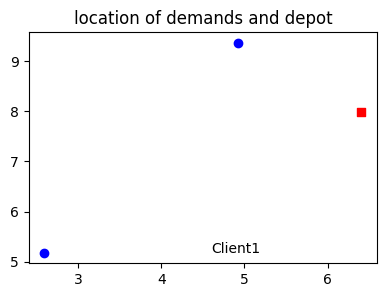

In [127]:
Clients = Locations[Locations['Type']=="Client"]
plt.scatter(Clients["Latitude"], Clients["Longitude"], c='b')
for i in range(0,number_of_clientes):
    plt.annotate(Clients["LocationName"].values[i], (Clients["Latitude"].iloc[i]+2, Clients["Longitude"].iloc[i]))

Depots = Locations[Locations['Type']=="Depot"] 
plt.scatter(Depots["Latitude"], Depots["Longitude"],c='r', marker='s')

for i in range(0,number_of_depots):
    plt.annotate(Depots["LocationName"].values[i], (Depots["Latitude"].iloc[i]+2, Depots["Longitude"].iloc[i]))   
    
plt.title("location of demands and depot");   

In [128]:
sm.InputTables.keys()

dict_keys(['Demand', 'Supply', 'Locations', 'Trucks', 'Compartments', 'Distances'])

# Build Model

In [129]:
mdl = Model(name='Toy_VRP')

In [130]:
Arc_truck = pd.merge(sm.InputTables['Distances'],Trucks["TruckID"], how = "cross")
Arc_truck= Arc_truck.set_index(["Origin","Destination","TruckID"])

Arc_truck["xArcDriven"] = binary_var_series(Arc_truck, mdl,name = 'ArcDriven')
Arc_truck.head()

Distance                        xArcDriven
Origin  Destination TruckID                                            
Client1 Client2     Truck1   4.782159  ArcDriven_Client1_Client2_Truck1
        Depot1      Truck1   4.734068   ArcDriven_Client1_Depot1_Truck1
Client2 Client1     Truck1   4.782159  ArcDriven_Client2_Client1_Truck1
        Depot1      Truck1   2.021130   ArcDriven_Client2_Depot1_Truck1
Depot1  Client1     Truck1   4.734068   ArcDriven_Depot1_Client1_Truck1

Vehicle leaves node that it enters, Ensure that the number of times a vehicle enters a node is equal to the number of times it leaves that node:

$\sum_{i=1}^{n} x_{ijk} =  \sum_{i=1}^{n} x_{jik}$            for every j in locations and k in truck list

In [131]:
outgoing_drives =  pd.DataFrame ( Arc_truck["xArcDriven"].groupby(["Origin","TruckID"]).agg( Times_truck_leave_location="sum") ).reset_index(drop = False)
Incoming_drives =  pd.DataFrame ( Arc_truck["xArcDriven"].groupby(["Destination","TruckID"]).agg(Times_truck_enter_location ="sum") ).reset_index(drop = False)

display( Incoming_drives.head(3))
display( outgoing_drives.head(3))

Incoming_outgoing_drives = pd.merge(Incoming_drives,outgoing_drives, how = "outer", left_on = ["Destination","TruckID"], right_on = ["Origin","TruckID"]  )
display( Incoming_outgoing_drives.head(3))

for row in Incoming_outgoing_drives.itertuples():
    mdl.add_constraint(row.Times_truck_enter_location== row.Times_truck_leave_location)

,Destination,TruckID,Times_truck_enter_location
0,Client1,Truck1,ArcDriven_Client2_Client1_Truck1+ArcDriven_Depot1_Client1_Truck1
1,Client2,Truck1,ArcDriven_Client1_Client2_Truck1+ArcDriven_Depot1_Client2_Truck1
2,Depot1,Truck1,ArcDriven_Client1_Depot1_Truck1+ArcDriven_Client2_Depot1_Truck1


,Origin,TruckID,Times_truck_leave_location
0,Client1,Truck1,ArcDriven_Client1_Client2_Truck1+ArcDriven_Client1_Depot1_Truck1
1,Client2,Truck1,ArcDriven_Client2_Client1_Truck1+ArcDriven_Client2_Depot1_Truck1
2,Depot1,Truck1,ArcDriven_Depot1_Client1_Truck1+ArcDriven_Depot1_Client2_Truck1


,Destination,TruckID,Times_truck_enter_location,Origin,Times_truck_leave_location
0,Client1,Truck1,ArcDriven_Client2_Client1_Truck1+ArcDriven_Depot1_Client1_Truck1,Client1,ArcDriven_Client1_Client2_Truck1+ArcDriven_Client1_Depot1_Truck1
1,Client2,Truck1,ArcDriven_Client1_Client2_Truck1+ArcDriven_Depot1_Client2_Truck1,Client2,ArcDriven_Client2_Client1_Truck1+ArcDriven_Client2_Depot1_Truck1
2,Depot1,Truck1,ArcDriven_Client1_Depot1_Truck1+ArcDriven_Client2_Depot1_Truck1,Depot1,ArcDriven_Depot1_Client1_Truck1+ArcDriven_Depot1_Client2_Truck1


Ensure that every node is entered once. Together with the first constraint, it ensures that the every node is entered only once, and it is left by the same vehicle.

$\sum_{k=1}^{p} \sum_{i=1}^{n} x_{ijk} =   1$  for j in demand locations (all locations excluding terminal)

In [132]:
Terminals =  sm.InputTables['Locations'][sm.InputTables['Locations']["Type"]=="Depot"]["LocationName"].values
Entering_nodes = Arc_truck.reset_index(drop = False)
Entering_nodes= Entering_nodes[~Entering_nodes["Destination"].isin(Terminals)].set_index(["Origin","TruckID"])
Entering_nodes = Entering_nodes["xArcDriven"].groupby(["Origin","TruckID"]).agg(Times_truck_enter_location ="sum")

display( Entering_nodes.tail(3))

for row in Entering_nodes.itertuples():
    mdl.add_constraint(row.Times_truck_enter_location== 1)

,,Times_truck_enter_location
Origin,TruckID,
Client1,Truck1,ArcDriven_Client1_Client2_Truck1
Client2,Truck1,ArcDriven_Client2_Client1_Truck1
Depot1,Truck1,ArcDriven_Depot1_Client1_Truck1+ArcDriven_Depot1_Client2_Truck1


In [133]:
Terminals =  sm.InputTables['Locations'][sm.InputTables['Locations']["Type"]=="Depot"]["LocationName"].values
Entering_nodes = Arc_truck.reset_index(drop = False)
Entering_nodes= Entering_nodes[~Entering_nodes["Destination"].isin(Terminals)].set_index(["Destination","TruckID"])
#Entering_nodes
Entering_nodes = Entering_nodes["xArcDriven"].groupby(["Destination"]).agg(Times_truck_enter_location ="sum")
Entering_nodes
display( Entering_nodes.tail(3))

for row in Entering_nodes.itertuples():
    mdl.add_constraint(row.Times_truck_enter_location== 1)


,Times_truck_enter_location
Destination,
Client1,ArcDriven_Client2_Client1_Truck1+ArcDriven_Depot1_Client1_Truck1
Client2,ArcDriven_Client1_Client2_Truck1+ArcDriven_Depot1_Client2_Truck1


Every vehicle leaves the depot, Together with constraint 1, we know that every vehicle arrives again at the depot.

$\sum_{j=2}^{n} x_{ijk} =   1$  for all k

In [134]:
Outgoing_depot = Arc_truck.reset_index(drop = False)
Outgoing_depot= Outgoing_depot[Outgoing_depot["Origin"].isin(Terminals)].set_index(["Origin","TruckID"])
Outgoing_depot = Outgoing_depot["xArcDriven"].groupby("TruckID").agg(Times_truck_leaves_depot ="sum")

display( Outgoing_depot.tail(3))

#for row in Outgoing_depot.itertuples():
    #mdl.add_constraint(row.Times_truck_leaves_depot== 1)

,Times_truck_leaves_depot
TruckID,
Truck1,ArcDriven_Depot1_Client1_Truck1+ArcDriven_Depot1_Client2_Truck1


Capacity constraint :Respect the capacity of the vehicles. Note that all vehicles have the same capacity.

$\sum_{i=1}^{n} \sum_{j=2}^{n} x_{ijk} <=   Q$  for all $k$

In [135]:
Outgoing_arcs = Arc_truck.reset_index(drop = False)[['Origin','Destination','TruckID','xArcDriven']]
Outgoing_arcs= Outgoing_arcs[~Outgoing_arcs["Destination"].isin(Terminals)]#.set_index(["Origin","TruckID"])
df =  pd.merge(Outgoing_arcs,Demand, left_on = "Destination", right_on = "GasStationID" )
df["Delived_demand"]= df["xArcDriven"] * df["Quantity"]

delivery = df[["TruckID","Delived_demand"]].groupby("TruckID").sum().rename(columns = {"Delived_demand":"Total_route_demand"})
delivery["Unfulfilled_delivery_Truck"]=continuous_var_series(delivery,mdl, name = "Unfulfilled_delivery")
delivery["fulfilled_delivery_Truck"]=delivery["Total_route_demand"] - delivery["Unfulfilled_delivery_Truck"]


display(delivery)
for row in delivery.itertuples():
    mdl.add_constraint(row.Total_route_demand - row.Unfulfilled_delivery_Truck <= Truck_capacity)

,Total_route_demand,Unfulfilled_delivery_Truck,fulfilled_delivery_Truck
TruckID,,,
Truck1,9ArcDriven_Client1_Client2_Truck1+4ArcDriven_Client2_Client1_Truck1+4ArcDriven_Depot1_Client1_Truck1+9ArcDriven_Depot1_Client2_Truck1,Unfulfilled_delivery_Truck1,9ArcDriven_Client1_Client2_Truck1+4ArcDriven_Client2_Client1_Truck1+4ArcDriven_Depot1_Client1_Truck1+9ArcDriven_Depot1_Client2_Truck1-Unfulfilled_delivery_Truck1


multiple depots

$\sum_{j \in customers} x_{ijk} <=   1$  for all $k, i \in depots$

$\sum_{i \in customers} x_{ijk} <=   1$  for all $k, j \in depots$

In [136]:
Outgoing_depots = Arc_truck.reset_index(drop = False)
Outgoing_depots = Outgoing_depots[Outgoing_depots["Origin"].isin(Terminals)]
Outgoing_depots = Outgoing_depots[~Outgoing_depots["Destination"].isin(Terminals)]
Outgoing_depots = Outgoing_depots[["TruckID","Origin","xArcDriven"]].groupby(["TruckID","Origin"]).sum()

display(Outgoing_depots)

for row in Outgoing_depots.itertuples():
    mdl.add_constraint(row.xArcDriven<= 1)

,,xArcDriven
TruckID,Origin,
Truck1,Depot1,ArcDriven_Depot1_Client1_Truck1+ArcDriven_Depot1_Client2_Truck1


In [137]:
Ingoing_depots = Arc_truck.reset_index(drop = False)
Ingoing_depots = Ingoing_depots[Ingoing_depots["Destination"].isin(Terminals)]
Ingoing_depots = Ingoing_depots[~Ingoing_depots["Origin"].isin(Terminals)]

Ingoing_depots = Ingoing_depots[["TruckID","Destination","xArcDriven"]].groupby(["TruckID","Destination"]).sum()

display(Ingoing_depots)

for row in Ingoing_depots.itertuples():
    mdl.add_constraint(row.xArcDriven<= 1)

,,xArcDriven
TruckID,Destination,
Truck1,Depot1,ArcDriven_Client1_Depot1_Truck1+ArcDriven_Client2_Depot1_Truck1


each truck only exit one depot

In [138]:
Outgoing_depots = Arc_truck.reset_index(drop = False)
Outgoing_depots = Outgoing_depots[Outgoing_depots["Origin"].isin(Terminals)]
Outgoing_depots = Outgoing_depots[~Outgoing_depots["Destination"].isin(Terminals)]
df = Outgoing_depots[["TruckID","xArcDriven"]].groupby(["TruckID"]).sum()

display(df)

for row in df.itertuples():
    mdl.add_constraint(row.xArcDriven<= 1)

,xArcDriven
TruckID,
Truck1,ArcDriven_Depot1_Client1_Truck1+ArcDriven_Depot1_Client2_Truck1


Objective Function

In [139]:
delivery

,Total_route_demand,Unfulfilled_delivery_Truck,fulfilled_delivery_Truck
TruckID,,,
Truck1,9ArcDriven_Client1_Client2_Truck1+4ArcDriven_Client2_Client1_Truck1+4ArcDriven_Depot1_Client1_Truck1+9ArcDriven_Depot1_Client2_Truck1,Unfulfilled_delivery_Truck1,9ArcDriven_Client1_Client2_Truck1+4ArcDriven_Client2_Client1_Truck1+4ArcDriven_Depot1_Client1_Truck1+9ArcDriven_Depot1_Client2_Truck1-Unfulfilled_delivery_Truck1


In [140]:
Total_Distance = mdl.sum ( Arc_truck["xArcDriven"]*Arc_truck["Distance"])
mdl.add_kpi( Total_Distance,"Total_Distance")
            
Total_Unfulfilled_Demand= mdl.sum (  delivery["Unfulfilled_delivery_Truck"])
mdl.add_kpi(Total_Unfulfilled_Demand,"Total_Unfulfilled_Demand")

DecisionKPI(name=Total_Unfulfilled_Demand,expr=Unfulfilled_delivery_Truck1)

# Solve the optimization

In [141]:
Locations = sm.InputTables['Locations'].set_index("LocationName") 
Clients = Locations[Locations['Type']=="Client"]
Depots = Locations[Locations['Type']=="Depot"] 

In [142]:
def find_subtours(Solution):
    
    graph  = nx.Graph()
        
    def create_node(name):
        graph.add_node(name)

    def create_edge(Origin,Destination):
        graph.add_edge(Origin, Destination)

    Node_edges = Solution[Solution["xArcDrivenSol"]>0][["Origin","Destination","xArcDrivenSol"]]

    list(map(create_node,  Node_edges['Origin']));
    list(map(create_edge,  Node_edges['Origin'], Node_edges['Destination']));
    
    #plt.figure()
    #nx.draw(graph, node_size=500,with_labels=True, arrowsize=20, font_size=10 )

    components = list(nx.connected_components(graph))
    #if len(components) == 1:
        #return []
    #else:
    return components
    
    

def find_subtours_without_depot (Solution, Depots ):

    subtours = find_subtours(Solution)
    Subtours_without_depot = []
    for subtour in subtours:
        nodes_of_subtour =subtour
        edges_of_subtour=[i for i in pairs(nodes_of_subtour)]
        Depots_in_subtour = [i for i in Depots if i in nodes_of_subtour]
        if len(Depots_in_subtour) ==0:
            Subtours_without_depot.append(subtour)
    return Subtours_without_depot

In [143]:
penalization_factor = 100

In [144]:
%%time

mdl.time_limit= 60 * 1
mdl.minimize(Total_Distance+penalization_factor * Total_Unfulfilled_Demand)
mdl.solve() #log_output=True


Solution = extract_solution(Arc_truck, drop = False, extract_dvar_names =["xArcDriven"]).reset_index(drop = False)
#Solution

subtours = find_subtours_without_depot (Solution, Depots.index )

print("Find Subtours")
i=0
while subtours:
    i=i+1
    print("Interation "+str(i)+ ": "+str(len(subtours))+ " subtours are found")
    for subtour in subtours:
        nodes_of_subtour = subtour
        SubtourRoutes = Arc_truck[["xArcDriven"]].reset_index(drop = False)
        SubtourRoutes = SubtourRoutes[ (~SubtourRoutes["Origin"].isin(Depots.index)) &  (~SubtourRoutes["Destination"].isin(Depots.index))]
        edges_trucks_of_subtour = SubtourRoutes[(SubtourRoutes["Origin"].isin(nodes_of_subtour)) & (SubtourRoutes["Destination"].isin(nodes_of_subtour))]
        subtour_arcs_summation = edges_trucks_of_subtour[["TruckID","xArcDriven"]].groupby("TruckID").sum().rename(columns = {"xArcDriven":"xArcDrivenTourSum"})  
        subtour_arcs_summation["Number_nodes_subtour"]= len(nodes_of_subtour)
        #display(subtour_arcs_summation)

            #print("Interation "+str(i)+ ": add " + str(len(subtour_arcs_summation)) + " constraints")
        for row in subtour_arcs_summation.itertuples():
            mdl.add_constraint(row.xArcDrivenTourSum <= row.Number_nodes_subtour - 1 )
    else:
        subtours=[]

    mdl.minimize(Total_Distance+penalization_factor * Total_Unfulfilled_Demand)
    mdl.solve() #log_output=True
    print("Solved Again!")
    Solution = extract_solution(Arc_truck, drop = False, extract_dvar_names =["xArcDriven"]).reset_index(drop = False)
    subtours = find_subtours_without_depot (Solution, Depots.index )
        
print("Removed Subtours!")

DOcplexException: Model<Toy_VRP> did not solve successfully

In [ ]:
mdl.print_information()

In [ ]:
mdl.report()

In [ ]:
cmap=plt.cm.get_cmap("Set1", number_of_trucks)
#https://matplotlib.org/stable/tutorials/colors/colormaps.html

plt.scatter(Clients["Latitude"], Clients["Longitude"], c='y', s=200)
for i in range(0,number_of_clientes):
    plt.annotate(Clients.index.values[i], (Clients["Latitude"].iloc[i]+2, Clients["Longitude"].iloc[i]))


plt.scatter(Depots["Latitude"], Depots["Longitude"],c='c', marker='s', s=200)
for i in range(0,number_of_depots):
    plt.annotate(Depots.index.values[i], (Depots["Latitude"].iloc[i]+2, Depots["Longitude"].iloc[i])) 
    

for row in Solution.itertuples() :
    if row.xArcDrivenSol>0:
        x=Locations.loc[row.Origin]["Latitude"]
        y=Locations.loc[row.Origin]["Longitude"]
        dx=Locations.loc[row.Destination]["Latitude"] - Locations.loc[row.Origin]["Latitude"]
        dy=Locations.loc[row.Destination]["Longitude"] - Locations.loc[row.Origin]["Longitude"]
        
        truck_index = np.where ( Trucks["TruckID"].values == row.TruckID )[0]    
        plt.arrow(x, y, dx, dy, head_width=3, color=cmap(truck_index))     
          

        #plt.plot([Locations.loc[row.Origin]["Latitude"], Locations.loc[row.Destination]["Latitude"]], [Locations.loc[row.Origin]["Longitude"], Locations.loc[row.Destination]["Longitude"]], c='g', alpha=0.3)

    
plt.title("routes between demands and depots");  

In [ ]:
Solution[Solution["xArcDrivenSol"]>0].sort_values("TruckID")

In [ ]:
extract_solution(delivery, drop = True, extract_dvar_names =["Total_route_demand","fulfilled_delivery_Truck","Unfulfilled_delivery_Truck"]).reset_index(drop = False)   

In [ ]:
Demand["Quantity"].sum()